# Problem statement

We have data from a Portuguese bank on details of customers related to selling a term deposit
The objective of the project is to help the marketing team identify potential customers who are relatively more likely to subscribe to the term deposit and this increase the hit ratio

# Data dictionary

**Bank client data**
* 1 - age 
* 2 - job : type of job 
* 3 - marital : marital status
* 4 - education 
* 5 - default: has credit in default? 
* 6 - housing: has housing loan? 
* 7 - loan: has personal loan?
* 8 - balance in account

**Related to previous contact**
* 8 - contact: contact communication type
* 9 - month: last contact month of year
* 10 - day_of_week: last contact day of the week
* 11 - duration: last contact duration, in seconds*

**Other attributes**
* 12 - campaign: number of contacts performed during this campaign and for this client
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign
* 14 - previous: number of contacts performed before this campaign and for this client
* 15 - poutcome: outcome of the previous marketing campaign

**Output variable (desired target):has the client subscribed a term deposit?**



In [1]:
# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# calculate accuracy measures and confusion matrix
from sklearn import metrics




c:\python\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Load the file from local directory using pd.read_csv which is a special form of read_table
#while reading the data, supply the "colnames" list

bank_df = pd.read_csv("bank-full.csv")


In [3]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
#### this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model

bank_df.drop(['duration'], inplace=True, axis=1)

#### Certain variables are more relevant if they are categorical variable than numerical variables. We will convert such categorical variables to numeric variabes

In [6]:
bank_df['day']=bank_df['day'].astype('category')
bank_df['Target']=bank_df['Target'].astype('category')

# Exploratory data analysis

## Univariate analysis - boxplot / histogram for numerical variables

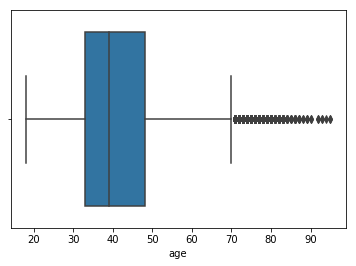

In [7]:
sns.boxplot(x=bank_df['age'], data=bank_df)

**Age column has some outliers. The median age is about 40 years. There are some customers above 90 years of age. This data might have to be checked**

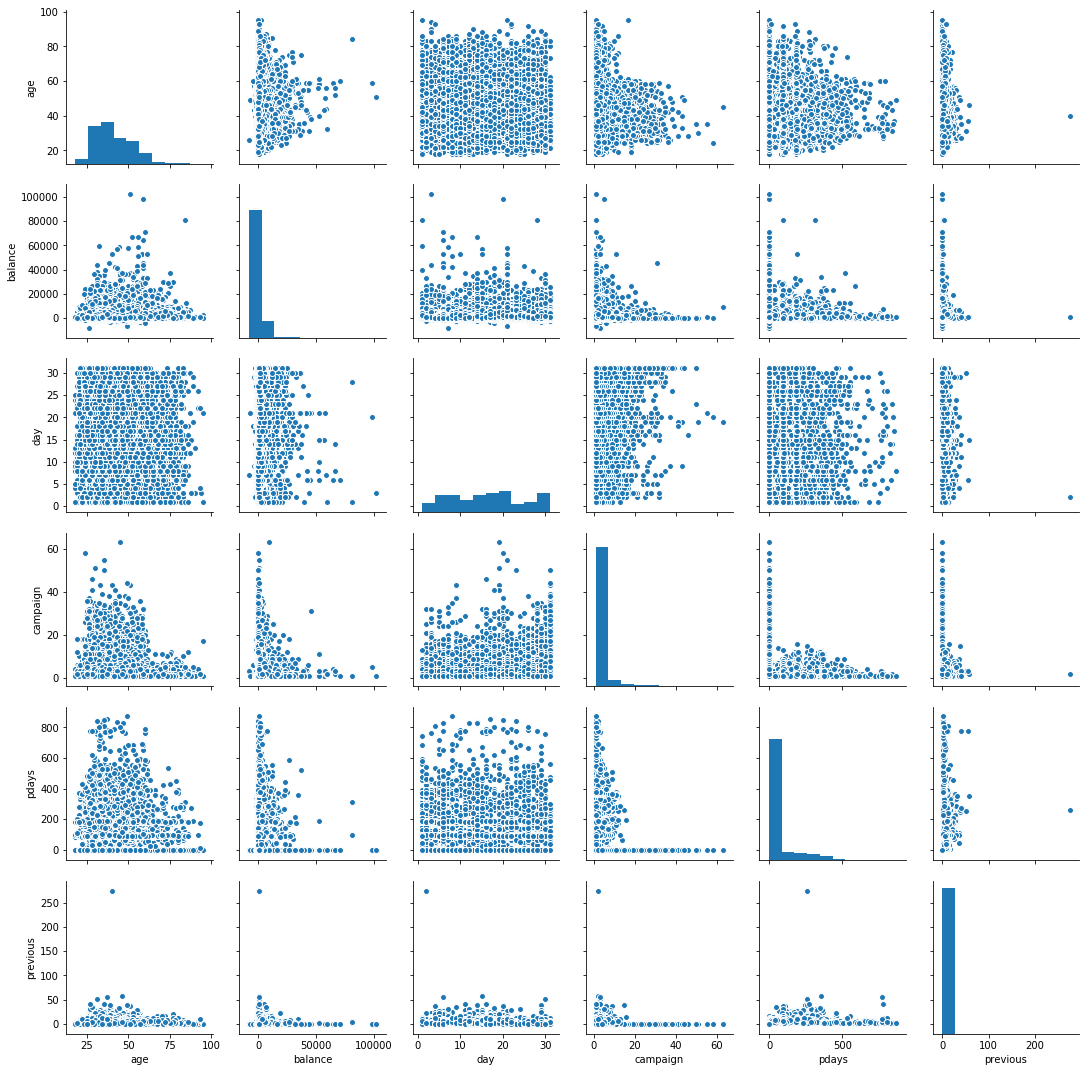

In [8]:
#histograms from the pair plots
sns.pairplot(bank_df)

**The distribution of all numerical variables other than age is highly skewed - hence we might want to transform or bin some of these variables**

**On similar lines, please perform univariate analysis of other numerical variables**

## Univariate analysis - countplot / value count for categorical variables

In [9]:
bank_df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

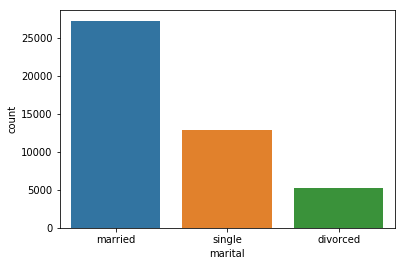

In [10]:
sns.countplot(bank_df['marital'])

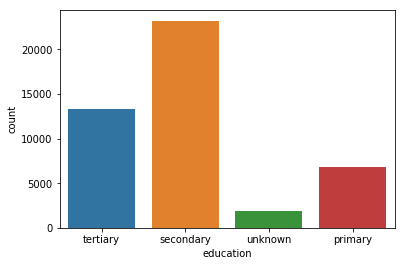

In [11]:
sns.countplot(bank_df['education'])

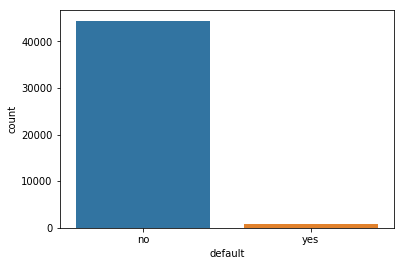

In [12]:
sns.countplot(bank_df['default'])

**default - yes is a very small % - we can consider deleting this column**

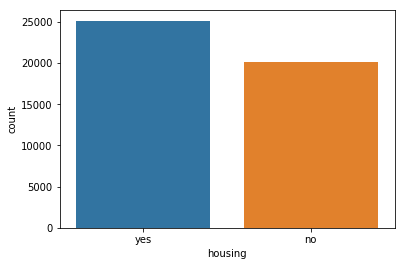

In [13]:
sns.countplot(bank_df['housing'])

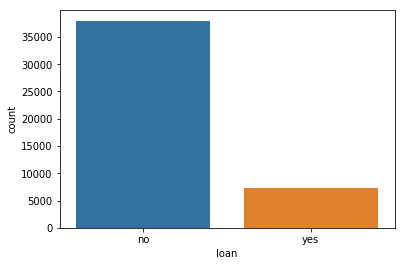

In [14]:
sns.countplot(bank_df['loan'])

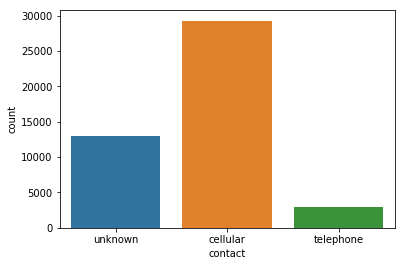

In [15]:
sns.countplot(bank_df['contact'])

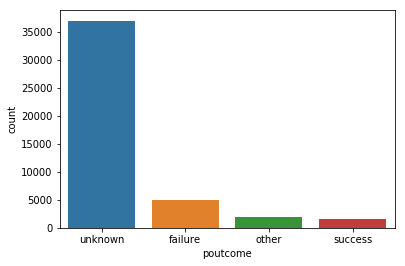

In [16]:
sns.countplot(bank_df['poutcome'])

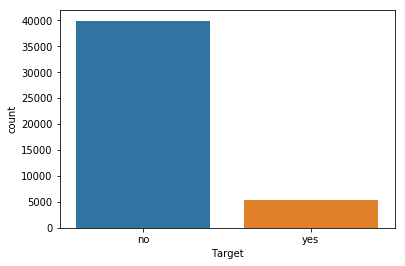

In [17]:
sns.countplot(bank_df['Target'])

In [18]:
bank_df['Target'].value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: Target, dtype: float64

### The response rate is only 11.6%. Hence the Y variable has a high class imbalance. Hence accuracy will not be a reliable model performance measure. 

### FN is very critical for this business case because a false negative is a customer who will potentially subscribe for a loan but who has been classified as 'will not subscribe'. Hence the most relevant model performance measure is recall

## Bivariate analysis

In [19]:
#Group numerical variables by mean for the classes of Y variable
np.round(bank_df.groupby(["Target"]).mean() ,1)

,age,balance,campaign,pdays,previous
Target,,,,,
no,40.8,1303.7,2.8,36.4,0.5
yes,41.7,1804.3,2.1,68.7,1.2


#### The mean balance is higher for customers who subscribe to the term deposit compared to those who dont


#### number of days that passed by after the client was last contacted from a previous campaign is higher for people who have subscribed

#### number of contacts performed before this campaign is also higher for customers who subscribe


### All of the above facts indicate that customers with a higher balance and those who have been contacted frequently before the campaign tend to subscribe for the term deposit

### Bivariate analysis using crosstab

In [20]:
pd.crosstab(bank_df['job'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
job,,
student,0.713220,0.286780
retired,0.772085,0.227915
unemployed,0.844973,0.155027
management,0.862444,0.137556
admin.,0.877973,0.122027
self-employed,0.881571,0.118429
unknown,0.881944,0.118056
technician,0.889430,0.110570
services,0.911170,0.088830


#### The highest conversion is for students (28%) and lowest is for blue-collar(7%

In [21]:
pd.crosstab(bank_df['marital'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
marital,,
single,0.850508,0.149492
divorced,0.880545,0.119455
married,0.898765,0.101235


In [22]:
pd.crosstab(bank_df['education'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
education,,
tertiary,0.849936,0.150064
unknown,0.864297,0.135703
secondary,0.894406,0.105594
primary,0.913735,0.086265


In [23]:
print(pd.crosstab(bank_df['default'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False ))
print(bank_df['default'].value_counts(normalize=True))

Target         no       yes
default                    
no       0.882039  0.117961
yes      0.936196  0.063804
no     0.981973
yes    0.018027
Name: default, dtype: float64


### Since default - yes is only 2% of the data and the conversion is also comparitively lower for default - yes, we can remove this column

In [24]:
bank_df.drop(['default'], axis=1, inplace=True)

In [25]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome',
       'Target'],
      dtype='object')

In [26]:
pd.crosstab(bank_df['housing'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
housing,,
no,0.832976,0.167024
yes,0.923000,0.077000


In [27]:
pd.crosstab(bank_df['loan'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
loan,,
no,0.873443,0.126557
yes,0.933186,0.066814


In [28]:
pd.crosstab(bank_df['contact'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
contact,,
cellular,0.850811,0.149189
telephone,0.865795,0.134205
unknown,0.959293,0.040707


In [29]:
pd.crosstab(bank_df['day'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )[0:10]

Target,no,yes
day,,
1,0.720497,0.279503
10,0.769084,0.230916
30,0.826948,0.173052
22,0.829834,0.170166
3,0.835032,0.164968
4,0.840830,0.159170
25,0.841667,0.158333
12,0.847785,0.152215
13,0.847950,0.152050


In [30]:
pd.crosstab(bank_df['month'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
month,,
mar,0.480084,0.519916
dec,0.532710,0.467290
sep,0.535406,0.464594
oct,0.562331,0.437669
apr,0.803206,0.196794
feb,0.833522,0.166478
aug,0.889867,0.110133
jun,0.897772,0.102228
nov,0.898489,0.101511


### List out the high level findings from bivariate analysis that could provide pointers to feature selection








In [31]:
#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

In [32]:
#Binning balance
cut_points = [0,500,1000, 1500,2000]
labels = ["very low","low","medium","high", "very high", "highest"]
bank_df['balance_range'] = binning(bank_df['balance'], cut_points, labels)
bank_df['balance_range'].value_counts()


low          16385
highest       8501
very low      7280
medium        6915
high          3736
very high     2394
Name: balance_range, dtype: int64

In [33]:
#Binning campaign
cut_points = [2,3,4]
labels = ["<=2","3","4",">4"]
bank_df['campaign_range'] = binning(bank_df['campaign'], cut_points, labels)
bank_df['campaign_range'].value_counts()


<=2    30049
>4      6119
3       5521
4       3522
Name: campaign_range, dtype: int64

In [34]:
bank_df.drop(['balance', 'campaign'], axis=1, inplace=True)
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'day', 'month', 'pdays', 'previous', 'poutcome', 'Target',
       'balance_range', 'campaign_range'],
      dtype='object')

In [35]:
X = bank_df.drop("Target" , axis=1)
y = bank_df["Target"]   # select all rows and the 17 th column which is the classification "Yes", "No"
X = pd.get_dummies(X, drop_first=True)

In [36]:
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [37]:
X_train.shape,X_test.shape

((31647, 75), (13564, 75))

In [38]:
#instantiating decision tree as the default model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
# Is the model an overfit model? 
y_pred = dt_model.predict(X_test)
print(dt_model.score(X_train, y_train))
print(dt_model.score(X_test , y_test))

0.9987360571302177
0.8359628428192274


In [40]:
# Note: - Decision Tree is a non-parametric algorithm and hence prone to overfitting easily. This is evident from the difference
# in scores in training and testing

# In ensemble techniques, we want multiple instances (each different from the other) and each instance to be overfit!!!  
# hopefully, the different instances will do different mistakes in classification and when we club them, their
# errors will get cancelled out giving us the benefit of lower bias and lower overall variance errors.



In [41]:
#Confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score

print(confusion_matrix(y_test, y_pred))

print(accuracy_score(y_test, y_pred))


print(recall_score(y_test, y_pred,average="binary", pos_label="yes"))




[[10845  1185]
 [ 1040   494]]
0.8359628428192274
0.3220338983050847


#### The recall score is relatively low and this has to be improves in the model

In [42]:
clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

## Visualizing the tree

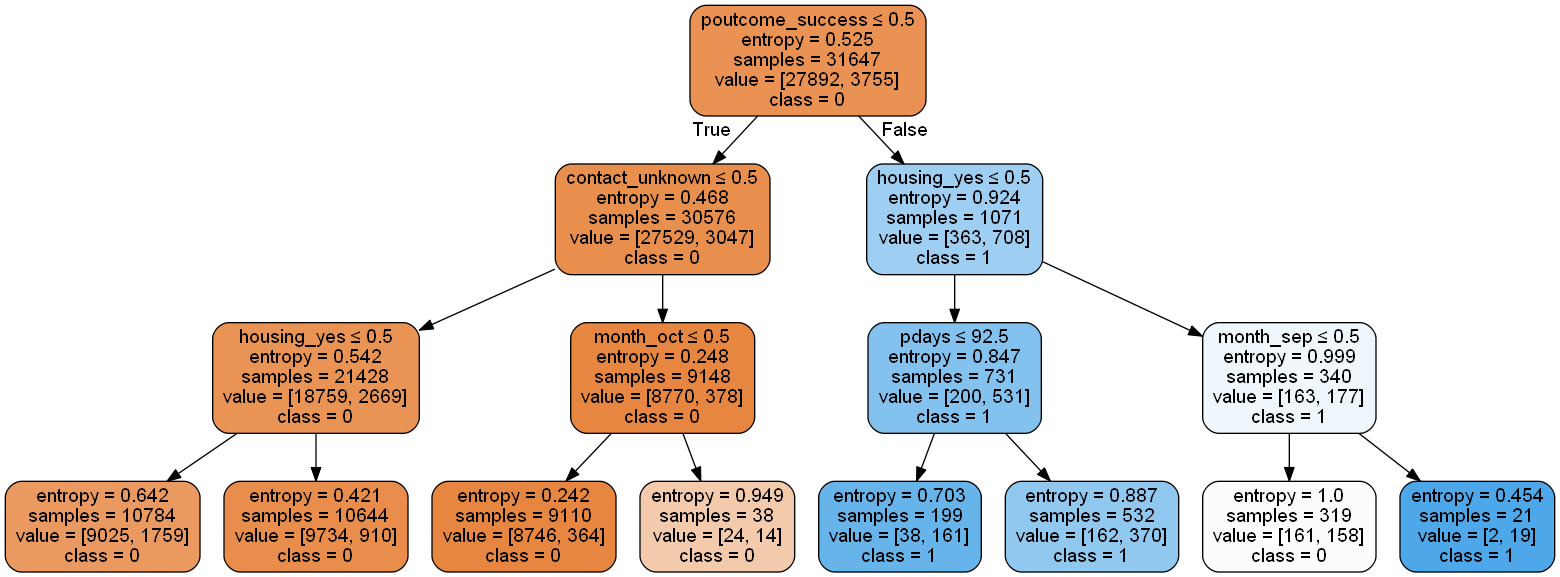

In [43]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz


feature_cols = X_train.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bank_pruned.png')
Image(graph.create_png())

In [44]:
## Calculating feature importance

feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)


feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)[0:10] #Top 10 features

,0
poutcome_success,0.652601
contact_unknown,0.202537
housing_yes,0.121260
month_oct,0.014702
month_sep,0.005419
pdays,0.003482
day_23,0.000000
day_24,0.000000
day_25,0.000000
day_26,0.000000


In [45]:
preds_pruned = clf_pruned.predict(X_test)
preds_pruned_train = clf_pruned.predict(X_train)


In [46]:
acc_DT = accuracy_score(y_test, preds_pruned)
recall_DT = recall_score(y_test, preds_pruned, average="binary", pos_label="yes")

In [47]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT, 'recall': recall_DT})
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941


### Overfitting is reduced after pruning, but recall has drastically reduced

In [48]:
## Apply the Random forest model and print the accuracy of Random forest Model


from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)






In [49]:
pred_RF = rfcl.predict(X_test)
acc_RF = accuracy_score(y_test, pred_RF)
recall_RF = recall_score(y_test, pred_RF, average="binary", pos_label="yes")

In [50]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RF], 'recall': [recall_RF]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.889782,0.215776


In [51]:
## Apply Adaboost Ensemble Algorithm for the same data and print the accuracy.


from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier( n_estimators= 200, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train, y_train)






In [52]:
pred_AB =abcl.predict(X_test)
acc_AB = accuracy_score(y_test, pred_AB)
recall_AB = recall_score(y_test, pred_AB, pos_label='yes')

In [53]:
tempResultsDf = pd.DataFrame({'Method':['Adaboost'], 'accuracy': [acc_AB], 'recall':[recall_AB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.889782,0.215776
0,Adaboost,0.893689,0.151890


In [54]:
## Apply Bagging Classifier Algorithm and print the accuracy


from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=100, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train, y_train)







In [55]:
pred_BG =bgcl.predict(X_test)
acc_BG = accuracy_score(y_test, pred_BG)
recall_BG = recall_score(y_test, pred_BG, pos_label='yes')

In [56]:
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'accuracy': [acc_BG], 'recall':[recall_BG]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.889782,0.215776
0,Adaboost,0.893689,0.151890
0,Bagging,0.889929,0.241851


In [57]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(X_train, y_train)






In [58]:
pred_GB =gbcl.predict(X_test)
acc_GB = accuracy_score(y_test, pred_GB)
recall_GB = recall_score(y_test, pred_GB, pos_label='yes')


In [59]:
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost'], 'accuracy': [acc_GB], 'recall':[recall_GB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.889782,0.215776
0,Adaboost,0.893689,0.151890
0,Bagging,0.889929,0.241851
0,Gradient Boost,0.894279,0.212516


### Bagging gives overall best model performance. However, please note that the recall is still very low and will have to be improved